In [1]:
import os
import sys
from pprint import pprint
from dotenv import load_dotenv
import pandas as pd
import numpy as np
#import seaborn as sns
#import time
import xgboost as xgb
from xgboost import plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import operator
import random
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization
import pandas_profiling
load_dotenv('forecast_arosa.env')
random.seed(22)

# Open CSV


In [2]:
path_in = os.getenv('DATAIN') # this is where we downloaded the tabel

In [3]:
file_name = os.getenv('DATASET_FILENAME') # this is where we downloaded the tabel

In [4]:
os.path.join(path_in, file_name)

'../arosa_data/arosa_data_feature1.csv'

In [5]:
df = pd.read_csv(os.path.join(path_in, file_name),delimiter=';')
df

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
0,01.01.2016,Freitag,winter season,1,53,1,1,1,0,NaN,...,0.81,1.3,2.6,1.1,0,0,10,20,5,35
1,02.01.2016,Samstag,winter season,2,53,1,1,1,0,NaN,...,1.21,1.9,5.4,0.0,0,0,78,59,22,159
2,03.01.2016,Sonntag,winter season,3,53,1,1,1,0,NaN,...,0.23,0.0,5.9,0.0,0,0,0,0,0,0
3,04.01.2016,Montag,winter season,4,1,0,0,0,0,NaN,...,0.13,0.3,2.4,0.0,0,0,0,0,0,0
4,05.01.2016,Dienstag,winter season,5,1,0,0,0,0,NaN,...,0.00,0.0,3.4,1.3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,27.08.2019,Dienstag,summer season,1335,35,0,0,0,0,NaN,...,0.00,0.0,11.2,0.0,2,0,59,26,29,114
1335,28.08.2019,Mittwoch,summer season,1336,35,0,0,0,0,NaN,...,0.00,0.0,5.6,1.1,2,0,61,40,19,120
1336,29.08.2019,Donnerstag,summer season,1337,35,0,0,0,0,NaN,...,0.16,0.0,5.8,0.0,2,0,76,38,23,137
1337,30.08.2019,Freitag,summer season,1338,35,0,0,0,0,NaN,...,0.00,0.0,5.7,0.7,3,0,157,48,27,232


In [6]:
df[df['Datum']=='31.08.2019']

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
1338,31.08.2019,Samstag,summer season,1339,35,1,1,1,0,NaN,...,0.03,0.0,5.8,2.9,3,0,183,33,23,239


In [7]:
len(df)

1339

# Overview of Data

In [8]:
#df.profile_report()

# Preprocessing

In [9]:
# df['Total Anfragen'].replace('-', 0)
#df[df['Total Anfragen']=='-']
#df.astype({'Total Anfragen': 'int32'}).dtypes

In [10]:
df['Total Anfragen'].dtypes

dtype('int64')

In [11]:
target_variable = 'Schalter'
col_names= list(df)
col_names.remove(target_variable)
col_names

['Datum',
 'Wochentag',
 'season',
 'TagNr',
 'WocheNr',
 'isFreiZH',
 'isFreiSG',
 'isFreiGR',
 'isFerienZH',
 'Ferien Desc ZH',
 'IsFerienZH_plus3',
 'isFerienZH_minus3',
 'isFerienSG',
 'Ferien Desc SG',
 'IsFerienSG_plus3',
 'isFerienSG_minus3',
 'isFerienGR',
 'Ferien Desc GR',
 'IsFerienGR_plus3',
 'isFerienGR_minus3',
 'Feiertag Desc',
 'isFeiertag ZH',
 'IsFeiertagZH_plus3',
 'isFeiertagZH_minus3',
 'isFeiertag SG',
 'IsFeiertagSG_plus3',
 'isFeiertagSG_minus3',
 'isFeiertag GR',
 'IsFeiertagGR_plus3',
 'isFeiertagGR_minus3',
 't_2m_c_avg',
 'snow_depth_cm_avg',
 'visibility_m_avg',
 'wind_speed_10m_ms_max',
 'prob_precip_1h_p_avg',
 'prob_tstorm_1h_p_avg',
 'hail_idx_avg',
 'wind_gusts_10m_ms_max',
 'wind_speed_mean_10m_24h_ms_avg',
 't_max_2m_24h_c_max',
 't_min_2m_24h_c_min',
 'precip_24h_mm_max',
 'fresh_snow_24h_cm_max',
 'is_sleet_1h_idx_max',
 'is_fog_1h_idx_max',
 'precip_1h_mm_sum',
 'fresh_snow_1h_cm_sum',
 'wind_speed_mean_10m_1h_ms_avg',
 'weather_symbol_1h_idx_spe'

In [12]:
df = df.dropna(subset=[target_variable])

In [13]:
nulls_per_column = df.isnull().sum()
print(nulls_per_column)

Datum                                0
Wochentag                            0
season                               0
TagNr                                0
WocheNr                              0
isFreiZH                             0
isFreiSG                             0
isFreiGR                             0
isFerienZH                           0
Ferien Desc ZH                    1024
IsFerienZH_plus3                     0
isFerienZH_minus3                    0
isFerienSG                           0
Ferien Desc SG                    1042
IsFerienSG_plus3                     0
isFerienSG_minus3                    0
isFerienGR                           0
Ferien Desc GR                     998
IsFerienGR_plus3                     0
isFerienGR_minus3                    0
Feiertag Desc                     1194
isFeiertag ZH                        0
IsFeiertagZH_plus3                   0
isFeiertagZH_minus3                  0
isFeiertag SG                        0
IsFeiertagSG_plus3       

In [14]:
df[df.Datum == '30.06.2018']

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
911,30.06.2018,Samstag,summer season,912,26,1,1,1,0,NaN,...,0.0,0.0,8.2,2.0,0,0,65,2,2,69


In [15]:
col_names= list(df)
col_names.remove(target_variable)
df= df[df.Datum != '09.03.2016']
col_names.remove('Tel')
col_names.remove('Mail')
col_names.remove('Total Anfragen')
col_names.remove('Datum')
df = df.dropna(subset=[target_variable])
X, y = df[col_names],df[target_variable]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=123,shuffle=False)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=123,shuffle=False)
X_train.tail()

,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,IsFerienZH_plus3,...,precip_24h_mm_max,fresh_snow_24h_cm_max,is_sleet_1h_idx_max,is_fog_1h_idx_max,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival
932,Samstag,summer season,933,29,1,1,1,1,Sommerferien,1,...,24.99,0.0,0,1,1.55,0.0,3.5,0.3,0,0
933,Sonntag,summer season,934,29,1,1,1,1,Sommerferien,1,...,10.40,0.0,0,0,0.09,0.0,6.7,0.0,0,0
934,Montag,summer season,935,30,1,1,1,1,Sommerferien,1,...,0.83,0.0,0,0,0.60,0.0,6.1,1.0,0,0
935,Dienstag,summer season,936,30,1,1,1,1,Sommerferien,1,...,4.90,0.0,0,0,0.00,0.0,6.9,0.0,0,0
936,Mittwoch,summer season,937,30,1,1,1,1,Sommerferien,1,...,0.00,0.0,0,0,0.00,0.0,7.2,0.9,0,0


# XGBoost Model

In [16]:
params1 = {'n_jobs': 8 }

pipeline1 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("xgb_model", xgb.XGBRegressor(**params1, objective='reg:squarederror')) 
                    ])

xgb_fit = pipeline1.fit(X_train.to_dict("records"), y_train)

/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [17]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
#Computing the MAE of our predictions
preds = xgb_fit.predict(X_test.to_dict("records"))
print("Mean Absolute Error : " + str(mean_absolute_error(preds, y_test)))
print("Mean Squared Error : " + str(mean_squared_error(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mape_vectorized_v2(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(y_test, preds)))

Mean Absolute Error : 13.79394056785166
Mean Squared Error : 277.03904073707275
Mean Absolute Percentage Error : 0.33394516535334273
Mean Absolute Percentage Error : inf


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
preds

array([69.94032  , 72.091515 , 76.9005   , 66.95416  , 71.52734  ,
       67.07724  , 59.64536  , 65.49324  , 68.992355 , 84.20682  ,
       76.40279  , 83.98203  , 64.81064  , 71.589386 , 68.923096 ,
       70.37989  , 79.84477  , 64.044586 , 37.903675 , 33.572506 ,
       42.382454 , 35.148    , 40.329136 , 35.03763  , 31.092909 ,
       36.37624  , 35.923595 , 30.498968 , 34.297718 , 35.082287 ,
       36.601566 , 27.799633 , 46.12047  , 38.754036 , 35.887764 ,
       30.173496 , 33.242104 , 33.902096 , 27.18129  , 37.629707 ,
       36.08855  , 44.210243 , 33.964783 , 36.918697 , 40.338535 ,
       31.32248  , 37.685642 , 35.913017 , 34.654053 , 34.297718 ,
       35.756847 , 41.635544 , 30.857042 , 40.295193 , 34.38315  ,
       31.526482 , 35.213123 , 40.886395 , 37.61284  , 41.61134  ,
       31.055582 , 31.714737 , 32.30297  , 31.688545 , 38.42051  ,
       38.062305 , 27.941898 , 31.681292 , 33.484146 , 29.77019  ,
       32.90131  , 48.79312  , 36.76753  , 30.535591 , 36.6878

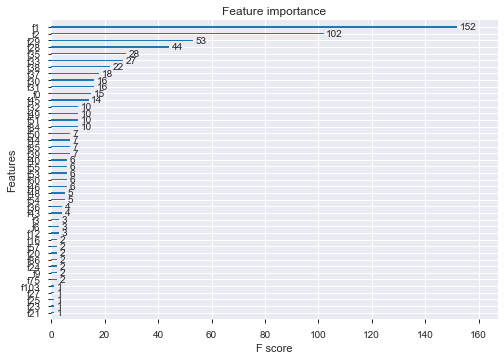

In [21]:
xgb.plot_importance(pipeline1._final_estimator)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [34]:
pipeline1.named_steps['vectorizer'].vocabulary_

{'Wochentag=Freitag': 0,
 'TagNr': 1,
 'WocheNr': 2,
 'isFreiZH': 3,
 'isFreiSG': 4,
 'isFreiGR': 5,
 'isFerienZH': 6,
 'Ferien Desc ZH': 7,
 'IsFerienZH_plus3': 8,
 'isFerienZH_minus3': 9,
 'isFerienSG': 10,
 'Ferien Desc SG': 11,
 'IsFerienSG_plus3': 12,
 'isFerienSG_minus3': 13,
 'isFerienGR': 14,
 'Ferien Desc GR': 15,
 'IsFerienGR_plus3': 16,
 'isFerienGR_minus3': 17,
 'Feiertag Desc=Neujahr': 18,
 'isFeiertag ZH': 19,
 'IsFeiertagZH_plus3': 20,
 'isFeiertagZH_minus3': 21,
 'isFeiertag SG': 22,
 'IsFeiertagSG_plus3': 23,
 'isFeiertagSG_minus3': 24,
 'isFeiertag GR': 25,
 'IsFeiertagGR_plus3': 26,
 'isFeiertagGR_minus3': 27,
 't_2m_c_avg': 28,
 'snow_depth_cm_avg': 29,
 'visibility_m_avg': 30,
 'wind_speed_10m_ms_max': 31,
 'prob_precip_1h_p_avg': 32,
 'prob_tstorm_1h_p_avg': 33,
 'hail_idx_avg': 34,
 'wind_gusts_10m_ms_max': 35,
 'wind_speed_mean_10m_24h_ms_avg': 36,
 't_max_2m_24h_c_max': 37,
 't_min_2m_24h_c_min': 38,
 'precip_24h_mm_max': 39,
 'fresh_snow_24h_cm_max': 40,
 'is_

In [24]:
def train_model(max_depth, 
                n_estimators,
                learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate':learning_rate,
        'n_jobs': 8 #number of CPU threads
    }

    pipeline = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

                        ])

    xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
    preds = xgb_fit.predict(X_val.to_dict("records"))
    mse = np.sqrt(mean_squared_error(preds, y_test))
    return -mse

bounds = {
    'max_depth':(5,100),
    'n_estimators': (100,10000),
    'learning_rate': (.001, 0.1),
}


In [25]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
    verbose=2,
)
best = optimizer.maximize(init_points=2, n_iter= 3)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -27.73    |  0.04229  |  73.43    |  101.1    |


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  2        | -27.55    |  0.03093  |  18.94    |  1.014e+0 |


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  3        | -27.59    |  0.1      |  5.0      |  1e+04    |


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  4        | -27.69    |  0.03031  |  100.0    |  5.67e+03 |


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|  5        | -28.03    |  0.1      |  100.0    |  3.194e+0 |
{'target': -27.54824513392604, 'params': {'learning_rate': 0.03093092469055214, 'max_depth': 18.941809627625737, 'n_estimators': 1014.1520882110982}}


In [37]:
params = {
    'n_estimators': 1000,
    'max_depth': 100,
    'learning_rate':0.001,
    'n_jobs': 8 #number of CPU threads
}

pipeline = Pipeline([
                 ("vectorizer", DictVectorizer(sort=False)),
                 ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),
                    ])

xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
preds = xgb_fit.predict(X_val.to_dict("records"))
mse = mean_absolute_error(preds, y_test)
mse

21.631477848510837

In [20]:
params2 = {
    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate':optimizer.max['params']['learning_rate'],
    'n_jobs': 8 #number of CPU threads
}

pipeline2 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(**params2))
                    ])

xgb_tuned_fit = pipeline2.fit(X_train.to_dict("records"), y_train)

NameError: name 'optimizer' is not defined

In [ ]:
preds = xgb_tuned_fit.predict(X_val.to_dict("records"))
mse = mean_absolute_error(preds, y_test)
mse

In [ ]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_file

df.sort_index(inplace=True)

source = ColumnDataSource(df)

p = figure(x_axis_type="datetime", plot_width=800, plot_height=350)
p.line(X_test[target_variable], preds)


# Preprocessing Error

In [166]:
pipeline = Pipeline([
                 ("vectorizer", DictVectorizer(sort=False)),
                                ])

test = pipeline.fit(X_train.to_dict("records"), y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'to_dict'

In [167]:
X_train.to_dict("records")

AttributeError: 'numpy.ndarray' object has no attribute 'to_dict'

In [168]:
DictVectorizer(X_train)

DictVectorizer(dtype=array([[2.000e+00, 1.000e+00, 5.300e+01, ..., 1.100e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 2.000e+00, 5.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.000e+00, 3.000e+00, 5.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 1.069e+03, 4.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.000e+00, 1.070e+03, 4.900e+01, ..., 5.000e-01, 0.000e+00,
        0.000e+00],
       [1.000e+00, 1.071e+03, 4.900e+01, ..., 0.000e+00, 1.000e+00,
        1.000e+00]]),
               separator='=', sort=True, sparse=True)

## LabelEncoder 

In [26]:
df['Ferien Desc ZH'].fillna(value=0, inplace = True)
df['Ferien Desc GR'].fillna(value=0, inplace = True)
df['Ferien Desc SG'].fillna(value=0, inplace = True)
df['Feiertag Desc'].fillna(value=0, inplace = True)

In [27]:
df = df.astype({"Ferien Desc ZH": str, "Ferien Desc GR": str, "Ferien Desc SG": str, "Feiertag Desc": str})

In [28]:
df['Ferien Desc ZH'].value_counts()

0                   1023
Sommerferien         145
Sportferien           64
Fruehlingsferien      61
Herbstferien          45
Name: Ferien Desc ZH, dtype: int64

In [29]:
df=df.drop(['Datum'],axis=1)
df

,Wochentag,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,IsFerienZH_plus3,isFerienZH_minus3,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
0,Freitag,1,53,1,1,1,0,0,0,0,...,0.81,1.3,2.6,1.1,0,0,10,20,5,35
1,Samstag,2,53,1,1,1,0,0,0,0,...,1.21,1.9,5.4,0.0,0,0,78,59,22,159
2,Sonntag,3,53,1,1,1,0,0,0,0,...,0.23,0.0,5.9,0.0,0,0,0,0,0,0
3,Montag,4,1,0,0,0,0,0,0,0,...,0.13,0.3,2.4,0.0,0,0,0,0,0,0
4,Dienstag,5,1,0,0,0,0,0,0,0,...,0.00,0.0,3.4,1.3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,Dienstag,1335,35,0,0,0,0,0,0,0,...,0.00,0.0,11.2,0.0,2,0,59,26,29,114
1335,Mittwoch,1336,35,0,0,0,0,0,0,0,...,0.00,0.0,5.6,1.1,2,0,61,40,19,120
1336,Donnerstag,1337,35,0,0,0,0,0,0,0,...,0.16,0.0,5.8,0.0,2,0,76,38,23,137
1337,Freitag,1338,35,0,0,0,0,0,0,0,...,0.00,0.0,5.7,0.7,3,0,157,48,27,232


In [30]:
# Create a boolean mask for categorical columns 
categorical_mask = (df.dtypes == object)  # true → is categorical
# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()
# Print the head of the categorical columns 
print(df[categorical_columns].head())
# Create LabelEncoder object: le 
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))
# Print the head of the LabelEncoded categorical columns print(df[categorical_columns].head())

  Wochentag Ferien Desc ZH Ferien Desc SG Ferien Desc GR  Feiertag Desc
0   Freitag              0              0              0        Neujahr
1   Samstag              0              0              0  Berchtoldstag
2   Sonntag              0              0              0              0
3    Montag              0              0              0              0
4  Dienstag              0              0              0              0


## One Hot Encoding

In [31]:
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded df_encoded = ohe.fit_transform(df)
# Print first 5 rows of the resulting dataset - again, this will no longer be a pandas dataframe print(df_encoded[:5, :])
# Print the shape of the original DataFrame 
d_encoded = ohe.fit_transform(df)
print(df.shape)
# Print the shape of the transformed array 
print(d_encoded.shape)
print(type(d_encoded))
d_encoded

(1338, 53)
(1338, 111)
<class 'numpy.ndarray'>


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[  0.,   0.,   1., ...,  20.,   5.,  35.],
       [  0.,   0.,   0., ...,  59.,  22., 159.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ...,  38.,  23., 137.],
       [  0.,   0.,   1., ...,  48.,  27., 232.],
       [  0.,   0.,   0., ...,  33.,  23., 239.]])

## Modelling

In [32]:
target_variable = 'Schalter'
col_names= list(df)
col_names.remove(target_variable)
col_names.remove('Tel')
col_names.remove('Mail')
col_names.remove('Total Anfragen')
#col_names.remove('Datum')
print(len(col_names))

print(d_encoded[:,:-4].shape)

49
(1338, 107)


In [33]:
X, y = d_encoded[:,:-4],d_encoded[:,-4]
print(X.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, 
                                                        random_state=122, shuffle=False)
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

(1338, 107)


In [36]:
params = {"booster":"gblinear","objective":"reg:linear"}
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)

rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

[10:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 41.194851


In [35]:
def train_model(max_depth, 
                n_estimators,
                learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate':learning_rate,
        'n_jobs': 8, #number of CPU threads
        "booster":"gblinear",
        "objective":"reg:squarederror"
    }

#     pipeline = Pipeline([
#                      ("vectorizer", DictVectorizer(sort=False)),
#                      ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

#                         ])
    
#     xgb_fit = pipeline.fit(DM_train)
#     preds = xgb_fit.predict(DM_test)
#     mse = mean_absolute_error(preds, y_test)

    xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)
    preds = xg_reg.predict(DM_test)
    mse = mean_absolute_error(preds, y_test)
    return -mse

bounds = {
    'max_depth':(5,100),
    'n_estimators': (100,10000),
    'learning_rate': (.001, 0.1),
}

In [183]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
    verbose=2,
)
best = optimizer.maximize(init_points=10, n_iter= 10)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
[09:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  1        | -23.82    |  0.04229  |  73.43    |  101.1    |
[09:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  2        | -24.39    |  0.03093  |  18.94    |  1.014e+0 |
[09:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  3        | -25.51    |  0.01944  |  37.83    |  4.028e+0 |
[09:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  4        | -23.55    |  0.05434  |  44.82    |  6.884e+0 |
[09:37:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  5        | -25.27    |  0.02124  |  88.42    